In [3]:
import pandas as pd
import numpy as np

In [7]:
df = pd.read_excel("online_retail_II.xlsx", sheet_name="Year 2010-2011")

In [11]:
df.head()
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


,Quantity,InvoiceDate,Price,Customer ID
count,541910.000000,541910,541910.000000,406830.000000
mean,9.552234,2011-07-04 13:35:22.342307584,4.611138,15287.684160
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.080957,NaN,96.759765,1713.603074


In [15]:
df = df[df['Customer ID'].notnull()]


In [19]:
df = df[df['Quantity'] > 0]
df = df[df['Price'] > 0]


In [25]:
df['TotalSpend'] = df['Quantity'] * df['Price']


In [29]:
df['Customer ID'] = df['Customer ID'].astype(int)


In [33]:
df.info()
df.describe()
len(df['Customer ID'].unique())

<class 'pandas.core.frame.DataFrame'>
Index: 397885 entries, 0 to 541909
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      397885 non-null  object        
 1   StockCode    397885 non-null  object        
 2   Description  397885 non-null  object        
 3   Quantity     397885 non-null  int64         
 4   InvoiceDate  397885 non-null  datetime64[ns]
 5   Price        397885 non-null  float64       
 6   Customer ID  397885 non-null  int32         
 7   Country      397885 non-null  object        
 8   TotalSpend   397885 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(4)
memory usage: 28.8+ MB


4338

In [37]:
import datetime as dt

latest_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
latest_date

Timestamp('2011-12-10 12:50:00')

In [41]:
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalSpend': 'sum'
})


In [49]:
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'TotalSpend': 'Monetary'
}, inplace=True)


In [51]:
rfm.head()
rfm.describe()


,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,92.536422,4.272015,2054.270609
std,100.014169,7.697998,8989.229895
min,1.000000,1.000000,3.750000
25%,18.000000,1.000000,307.415000
50%,51.000000,2.000000,674.485000
75%,142.000000,5.000000,1661.740000
max,374.000000,209.000000,280206.020000


In [55]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

In [59]:
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'], index=rfm.index)
rfm_scaled_df.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346,2.334574,-0.425097,8.358668
12347,-0.905340,0.354417,0.250966
12348,-0.175360,-0.035340,-0.028596
12349,-0.735345,-0.425097,-0.033012
12350,2.174578,-0.425097,-0.191348


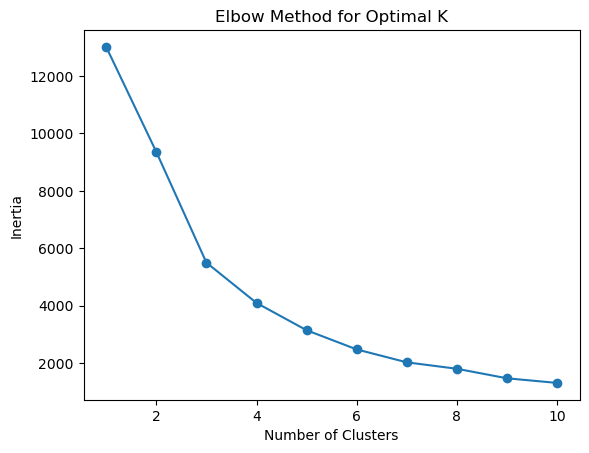

In [63]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled_df)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

In [67]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled_df)


In [71]:
kmeans.cluster_centers_

array([[-0.48832448, -0.07656166, -0.07734762],
       [ 1.55535385, -0.35337933, -0.17508002],
       [-0.85149559, 10.16828936, 13.93873418],
       [-0.77034388,  2.34650634,  1.18542392]])

In [75]:
cluster_centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=['Recency', 'Frequency', 'Monetary']
)
cluster_centers

,Recency,Frequency,Monetary
0,43.702685,3.682711,1359.055178
1,248.075914,1.552015,480.617480
2,7.384615,82.538462,127338.313846
3,15.500000,22.333333,12709.090490


In [79]:
rfm['Cluster'].value_counts()

Cluster
0    3054
1    1067
3     204
2      13
Name: count, dtype: int64

In [85]:
cluster_summary = rfm.groupby('Cluster').agg(
    Recency=('Recency', 'mean'),
    Frequency=('Frequency', 'mean'),
    Monetary=('Monetary', 'mean'),
    Num_Customers=('Recency', 'count')   # just counts rows in each cluster
)

cluster_summary


,Recency,Frequency,Monetary,Num_Customers
Cluster,,,,
0,43.702685,3.682711,1359.055178,3054
1,248.075914,1.552015,480.617480,1067
2,7.384615,82.538462,127338.313846,13
3,15.500000,22.333333,12709.090490,204


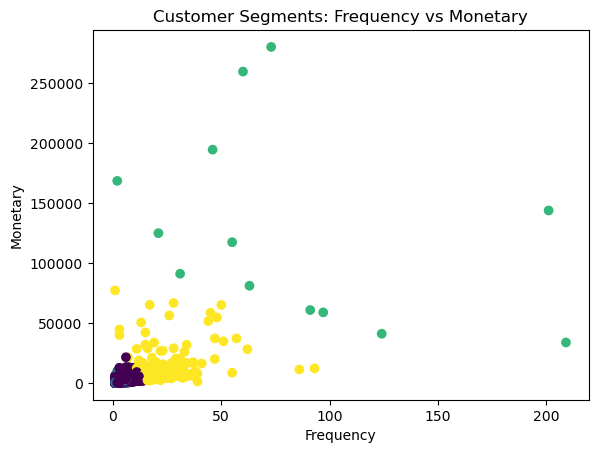

In [89]:
plt.scatter(rfm['Frequency'], rfm['Monetary'], c=rfm['Cluster'], cmap='viridis')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('Customer Segments: Frequency vs Monetary')
plt.show()

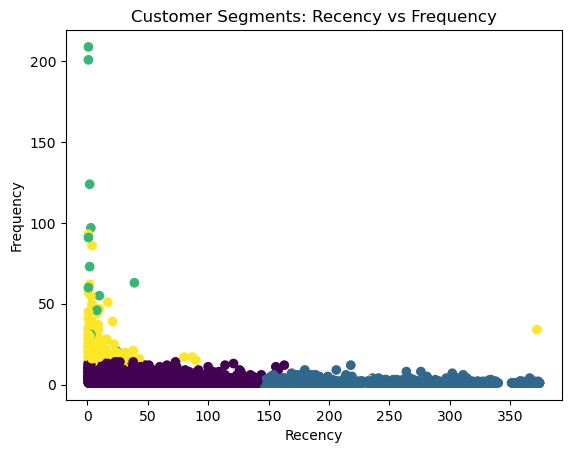

In [93]:
plt.scatter(rfm['Recency'], rfm['Frequency'], c=rfm['Cluster'], cmap='viridis')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('Customer Segments: Recency vs Frequency')
plt.show()


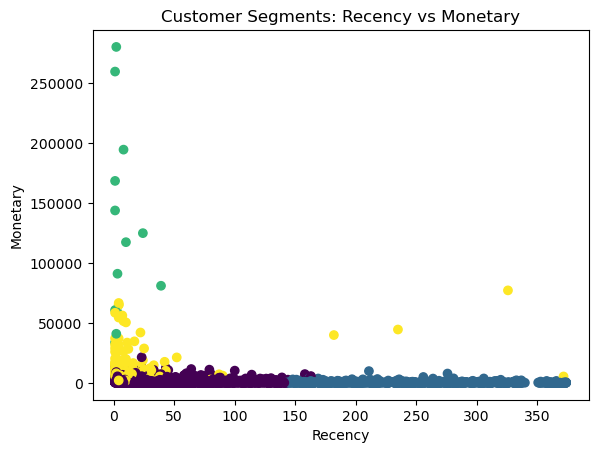

In [97]:
plt.scatter(rfm['Recency'], rfm['Monetary'], c=rfm['Cluster'], cmap='viridis')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.title('Customer Segments: Recency vs Monetary')
plt.show()

In [101]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Test several K values
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(rfm_scaled_df)
    score = silhouette_score(rfm_scaled_df, labels)
    print(f"K={k}, Silhouette Score={score:.3f}")

K=2, Silhouette Score=0.560
K=3, Silhouette Score=0.585
K=4, Silhouette Score=0.616
K=5, Silhouette Score=0.617
K=6, Silhouette Score=0.598


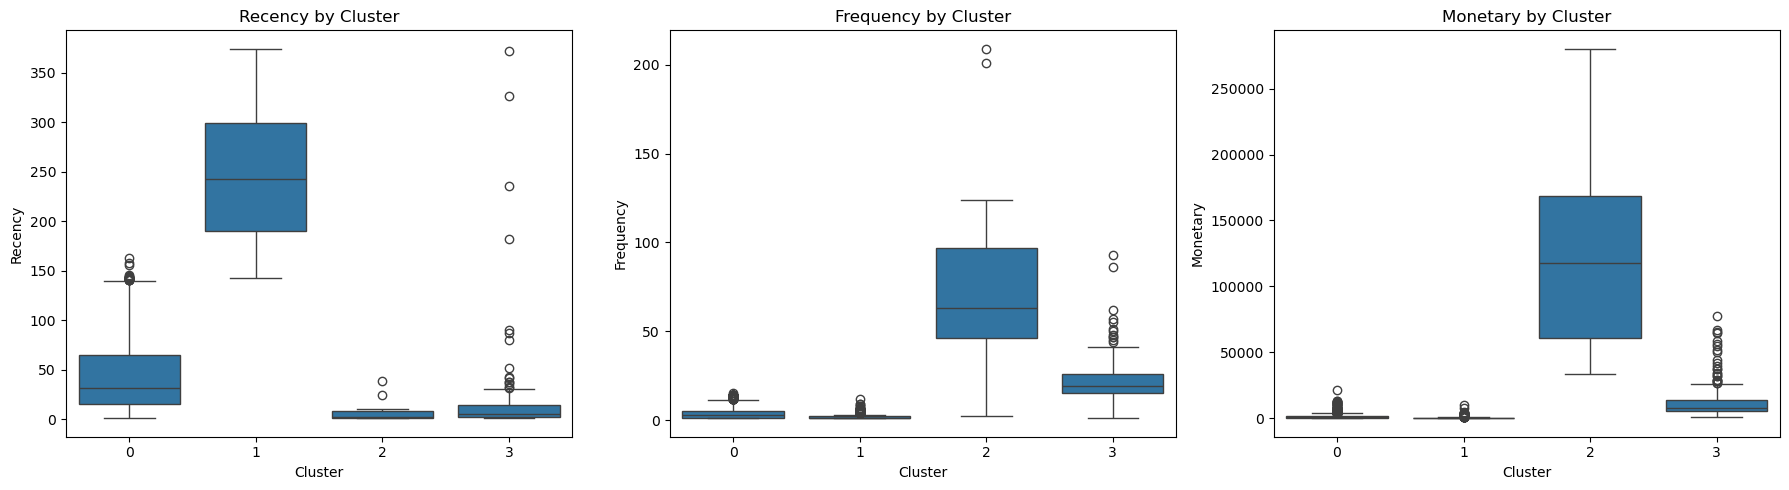

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(x='Cluster', y='Recency', data=rfm, ax=axes[0])
axes[0].set_title('Recency by Cluster')

sns.boxplot(x='Cluster', y='Frequency', data=rfm, ax=axes[1])
axes[1].set_title('Frequency by Cluster')

sns.boxplot(x='Cluster', y='Monetary', data=rfm, ax=axes[2])
axes[2].set_title('Monetary by Cluster')

plt.tight_layout()
plt.show()

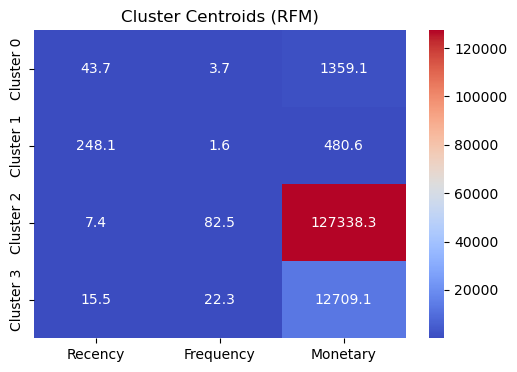

In [107]:
# cluster_centers already created earlier
import pandas as pd

cluster_centers.index = [f"Cluster {i}" for i in cluster_centers.index]

plt.figure(figsize=(6,4))
sns.heatmap(cluster_centers, annot=True, fmt=".1f", cmap='coolwarm')
plt.title("Cluster Centroids (RFM)")
plt.show()

In [109]:
# Total revenue per cluster
revenue_by_cluster = rfm.groupby('Cluster')['Monetary'].sum().rename('TotalRevenue')

# Number of customers per cluster (you already have Num_Customers)
counts_by_cluster = rfm['Cluster'].value_counts().rename('Num_Customers')

rev_summary = pd.concat([revenue_by_cluster, counts_by_cluster], axis=1)
rev_summary['AvgRevenuePerCustomer'] = rev_summary['TotalRevenue'] / rev_summary['Num_Customers']
rev_summary['RevenueShare_%'] = (rev_summary['TotalRevenue'] / rev_summary['TotalRevenue'].sum()) * 100

rev_summary

,TotalRevenue,Num_Customers,AvgRevenuePerCustomer,RevenueShare_%
Cluster,,,,
0,4150554.513,3054,1359.055178,46.575650
1,512818.851,1067,480.617480,5.754622
2,1655398.080,13,127338.313846,18.576130
3,2592654.460,204,12709.090490,29.093598


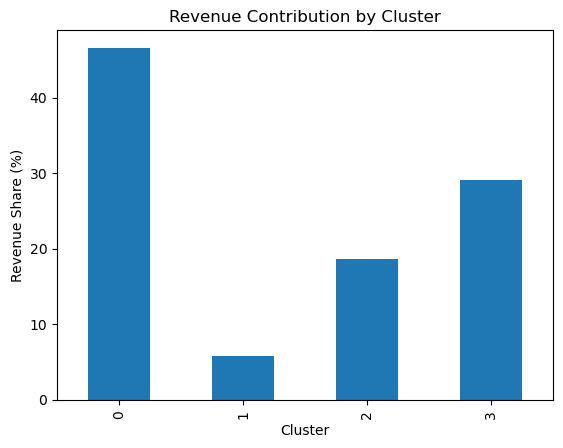

In [111]:
rev_summary['RevenueShare_%'].plot(kind='bar')
plt.ylabel('Revenue Share (%)')
plt.title('Revenue Contribution by Cluster')
plt.show()

In [113]:
# quintile-based scoring (1 = worst, 5 = best)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])  # lower recency = better
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 5, labels=[1,2,3,4,5])

rfm['R_Score'] = rfm['R_Score'].astype(int)
rfm['F_Score'] = rfm['F_Score'].astype(int)
rfm['M_Score'] = rfm['M_Score'].astype(int)

rfm['RFM_Total'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']
rfm[['R_Score','F_Score','M_Score','RFM_Total']].head()

,R_Score,F_Score,M_Score,RFM_Total
Customer ID,,,,
12346,1,1,5,7
12347,5,5,5,15
12348,2,4,4,10
12349,4,1,4,9
12350,1,1,2,4


In [115]:
rfm['AvgOrderValue'] = rfm['Monetary'] / rfm['Frequency']
# Simple CLV proxy over the 1-year period
rfm['CLV_Proxy'] = rfm['Monetary']  # total spend in the period

# Cluster-level CLV summary
clv_summary = rfm.groupby('Cluster').agg({
    'AvgOrderValue': 'mean',
    'CLV_Proxy': 'mean',
    'Frequency': 'mean'
}).rename(columns={'CLV_Proxy': 'Avg_CLV'})
clv_summary

,AvgOrderValue,Avg_CLV,Frequency
Cluster,,,
0,376.758412,1359.055178,3.682711
1,314.811424,480.617480,1.552015
2,8570.727706,127338.313846,82.538462
3,1080.413842,12709.090490,22.333333


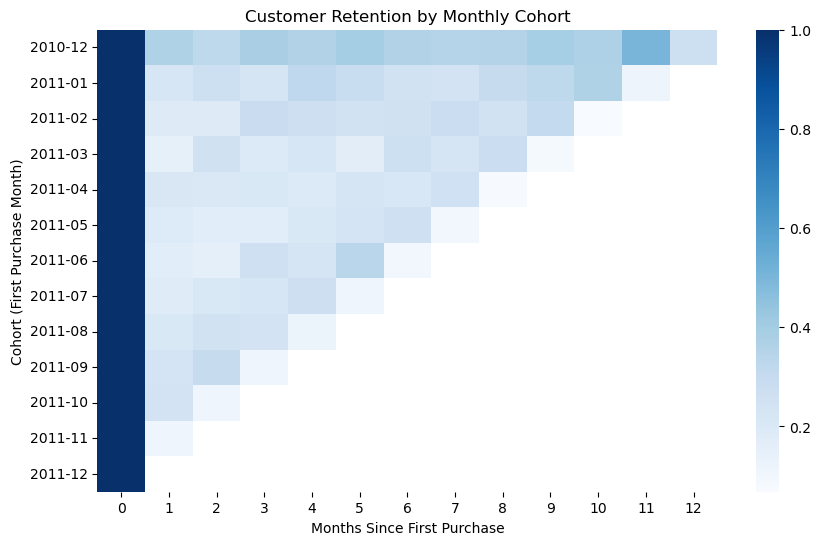

In [117]:
df_cohort = df.copy()

# Make sure InvoiceDate is datetime
df_cohort['InvoiceMonth'] = df_cohort['InvoiceDate'].dt.to_period('M')

# Define cohort: month of the customer's first purchase
df_cohort['CohortMonth'] = df_cohort.groupby('Customer ID')['InvoiceMonth'].transform('min')

# Cohort index (months since first purchase)
cohort_data = df_cohort.groupby(['CohortMonth', 'InvoiceMonth'])['Customer ID'].nunique().reset_index()
cohort_data['CohortIndex'] = (cohort_data['InvoiceMonth'] - cohort_data['CohortMonth']).apply(lambda x: x.n)

cohort_pivot = cohort_data.pivot_table(index='CohortMonth',
                                       columns='CohortIndex',
                                       values='Customer ID')

cohort_retention = cohort_pivot.divide(cohort_pivot.iloc[:,0], axis=0)

plt.figure(figsize=(10,6))
sns.heatmap(cohort_retention, annot=False, cmap='Blues')
plt.title('Customer Retention by Monthly Cohort')
plt.ylabel('Cohort (First Purchase Month)')
plt.xlabel('Months Since First Purchase')
plt.show()

In [119]:
pip install mlxtend

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 8.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [123]:
from mlxtend.frequent_patterns import apriori, association_rules

# 1. Filter to UK customers only (or any main country)
df_mb = df[df['Country'] == 'United Kingdom'].copy()

# 2. Build the basket: invoices x products
basket = (
    df_mb
    .groupby(['Invoice', 'StockCode'])['Quantity']
    .sum()
    .unstack()
    .fillna(0)
)

# 3. Optionally sample invoices to keep it manageable
sampled_invoices = basket.sample(n=10000, random_state=42)  # adjust n if needed
basket = sampled_invoices

# 4. Drop very rare products (columns with low total quantity)
basket = basket.loc[:, basket.sum() >= 50]   # keep only products that appear 50+ times

# 5. Convert to boolean (True/False)
basket_binary = basket > 0
basket_binary = basket_binary.astype(bool)

# 6. Run Apriori on the reduced, boolean matrix
frequent_itemsets = apriori(
    basket_binary,
    min_support=0.02,      # 2% support; adjust if you get too few/many rules
    use_colnames=True
)

frequent_itemsets.head()

,support,itemsets
0,0.0302,(20685)
1,0.0213,(20712)
2,0.0214,(20713)
3,0.0238,(20719)
4,0.0249,(20723)


In [125]:
rules = association_rules(
    frequent_itemsets,
    metric="lift",
    min_threshold=1.0
)

rules_sorted = rules.sort_values('lift', ascending=False)
rules_sorted.head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
79,(22697),"(22698, 22699)",0.0376,0.0230,0.0205,0.545213,23.704903,1.0,0.019635,2.148257,0.995235,0.511222,0.534506,0.718259
78,"(22698, 22699)",(22697),0.0230,0.0376,0.0205,0.891304,23.704903,1.0,0.019635,8.854080,0.980363,0.511222,0.887058,0.718259
80,(22698),"(22697, 22699)",0.0304,0.0290,0.0205,0.674342,23.253176,1.0,0.019618,2.981657,0.987000,0.526992,0.664616,0.690619
77,"(22697, 22699)",(22698),0.0290,0.0304,0.0205,0.706897,23.253176,1.0,0.019618,3.308047,0.985577,0.526992,0.697707,0.690619
50,(22697),(22698),0.0376,0.0304,0.0246,0.654255,21.521557,1.0,0.023457,2.804382,0.990789,0.566820,0.643415,0.731733
51,(22698),(22697),0.0304,0.0376,0.0246,0.809211,21.521557,1.0,0.023457,5.044303,0.983431,0.566820,0.801757,0.731733
81,(22699),"(22697, 22698)",0.0414,0.0246,0.0205,0.495169,20.128824,1.0,0.019482,1.932132,0.991362,0.450549,0.482437,0.664251
76,"(22697, 22698)",(22699),0.0246,0.0414,0.0205,0.833333,20.128824,1.0,0.019482,5.751600,0.974287,0.450549,0.826135,0.664251
52,(22697),(22699),0.0376,0.0414,0.0290,0.771277,18.629869,1.0,0.027443,4.191088,0.983295,0.580000,0.761398,0.735880
53,(22699),(22697),0.0414,0.0376,0.0290,0.700483,18.629869,1.0,0.027443,3.213174,0.987193,0.580000,0.688781,0.735880


In [129]:
rfm_spss = rfm[['Recency','Frequency','Monetary',
                'Cluster','AvgOrderValue','CLV_Proxy',
                'R_Score','F_Score','M_Score','RFM_Total']].copy()

rfm_spss.reset_index(inplace=True)   # brings Customer ID back as a column
rfm_spss.to_csv("rfm_spss.csv", index=False)

In [131]:
rfm_spss.to_csv(r"D:\Business Analytics\Term 2\Research Proposal\rfm_spss.csv", index=False)

In [3]:
import pandas as pd
import numpy as np

# Load the prepared RFM dataset from disk
rfm = pd.read_csv(r"D:\Business Analytics\Term 2\Research Proposal\rfm_spss.csv")

rfm.head()   # just to check it loaded correctly


,Customer ID,Recency,Frequency,Monetary,Cluster,AvgOrderValue,CLV_Proxy,R_Score,F_Score,M_Score,RFM_Total
0,12346,326,1,77183.60,3,77183.600000,77183.60,1,1,5,7
1,12347,2,7,4310.00,0,615.714286,4310.00,5,5,5,15
2,12348,75,4,1797.24,0,449.310000,1797.24,2,4,4,10
3,12349,19,1,1757.55,0,1757.550000,1757.55,4,1,4,9
4,12350,310,1,334.40,1,334.400000,334.40,1,1,2,4


In [7]:
# Define high-value clusters (2 and 3)
high_value_clusters = [2, 3]

# Create binary target variable
rfm['HighValue'] = rfm['Cluster'].apply(lambda x: 1 if x in high_value_clusters else 0)

rfm[['Cluster', 'HighValue']].head()


,Cluster,HighValue
0,3,1
1,0,0
2,0,0
3,0,0
4,1,0


In [11]:
from sklearn.model_selection import train_test_split

# Select features for modelling
features = ['Recency', 'Frequency', 'Monetary', 'AvgOrderValue', 
            'R_Score', 'F_Score', 'M_Score', 'RFM_Total']

X = rfm[features]
y = rfm['HighValue']

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((3470, 8), (868, 8))

In [15]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [19]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       825
           1       1.00      1.00      1.00        43

    accuracy                           1.00       868
   macro avg       1.00      1.00      1.00       868
weighted avg       1.00      1.00      1.00       868


Confusion Matrix:
 [[825   0]
 [  0  43]]


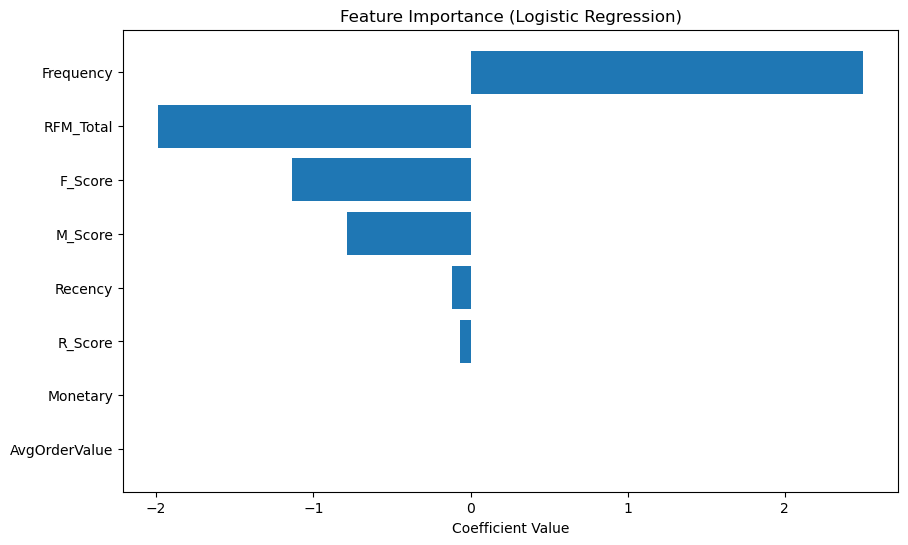

,Feature,Coefficient,AbsCoef
1,Frequency,2.495945,2.495945
7,RFM_Total,-1.986654,1.986654
5,F_Score,-1.138902,1.138902
6,M_Score,-0.783427,0.783427
0,Recency,-0.115478,0.115478
4,R_Score,-0.064324,0.064324
2,Monetary,0.001258,0.001258
3,AvgOrderValue,-0.000467,0.000467


In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Get model coefficients
importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
})

# Sort by absolute importance
importance['AbsCoef'] = importance['Coefficient'].abs()
importance = importance.sort_values('AbsCoef', ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.barh(importance['Feature'], importance['Coefficient'])
plt.xlabel("Coefficient Value")
plt.title("Feature Importance (Logistic Regression)")
plt.gca().invert_yaxis()
plt.show()

importance

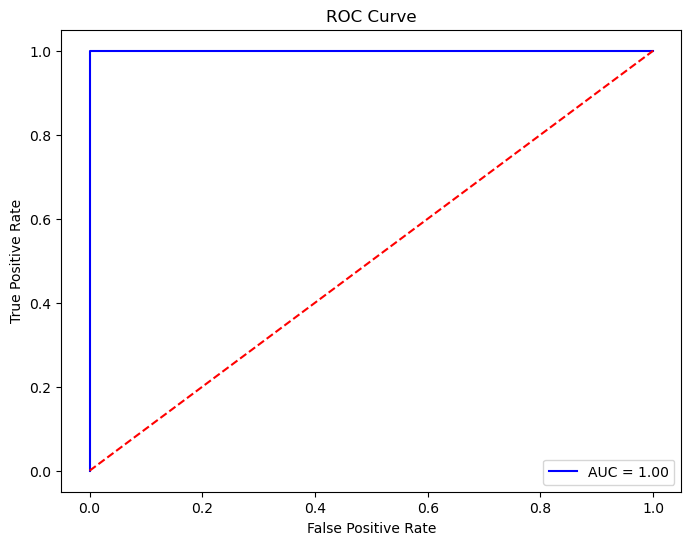

In [23]:
from sklearn.metrics import roc_curve, auc

y_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

Decision Tree Accuracy: 0.9988479262672811

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       825
           1       1.00      0.98      0.99        43

    accuracy                           1.00       868
   macro avg       1.00      0.99      0.99       868
weighted avg       1.00      1.00      1.00       868


Confusion Matrix:
 [[825   0]
 [  1  42]]


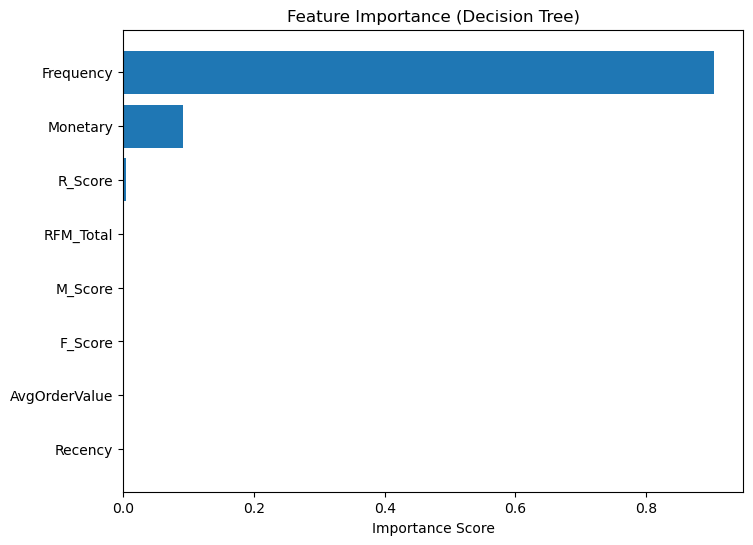

In [28]:
import matplotlib.pyplot as plt
import numpy as np

importances = dt.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8,6))
plt.barh(np.array(features)[indices], importances[indices])
plt.title("Feature Importance (Decision Tree)")
plt.xlabel("Importance Score")
plt.show()

In [30]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Random Forest Accuracy: 0.9988479262672811

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       825
           1       1.00      0.98      0.99        43

    accuracy                           1.00       868
   macro avg       1.00      0.99      0.99       868
weighted avg       1.00      1.00      1.00       868


Confusion Matrix:
 [[825   0]
 [  1  42]]


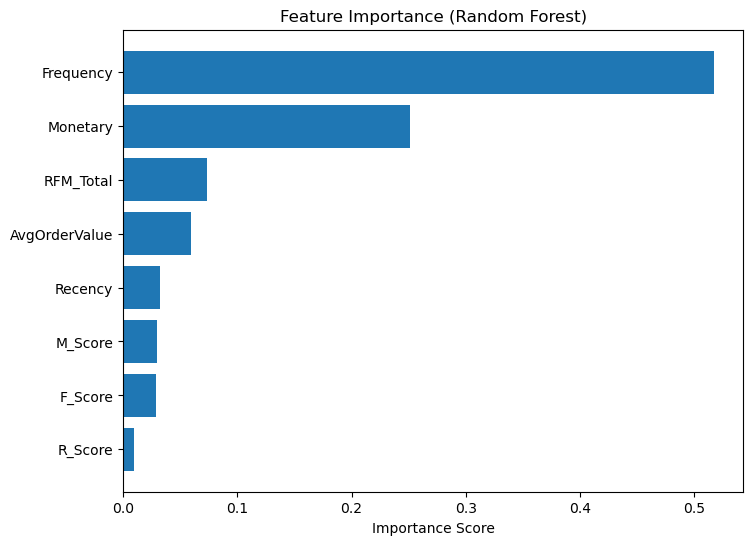

In [32]:
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8,6))
plt.barh(np.array(features)[indices], importances[indices])
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.show()

In [36]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)

print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_gb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))

Gradient Boosting Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       825
           1       1.00      1.00      1.00        43

    accuracy                           1.00       868
   macro avg       1.00      1.00      1.00       868
weighted avg       1.00      1.00      1.00       868


Confusion Matrix:
 [[825   0]
 [  0  43]]


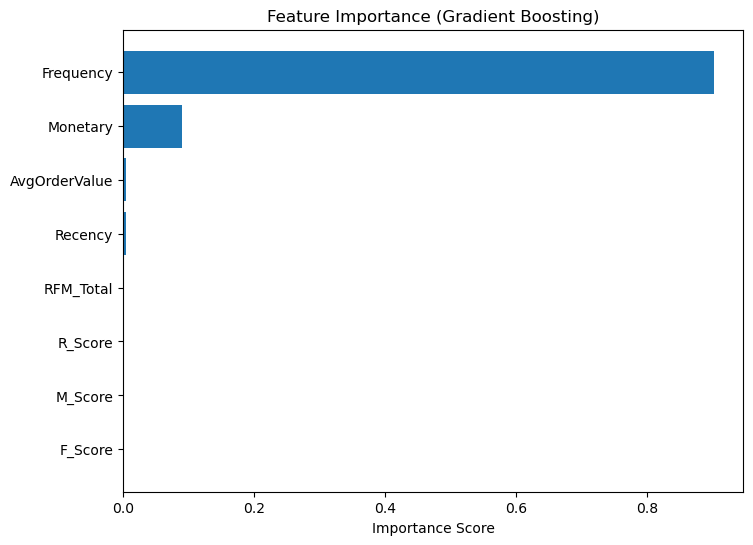

In [38]:
importances = gb.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8,6))
plt.barh(np.array(features)[indices], importances[indices])
plt.title("Feature Importance (Gradient Boosting)")
plt.xlabel("Importance Score")
plt.show()

In [42]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

In [46]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='f1')
grid.fit(X_resampled, y_resampled)

print("Best params:", grid.best_params_)

Best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}


In [50]:
!pip install shap

   ---------------------------------------- 0.0/549.3 kB ? eta -:--:--
   --------------------------------------- 549.3/549.3 kB 19.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/15.6 MB ? eta -:--:--
   -------------------- ------------------- 8.1/15.6 MB 38.7 MB/s eta 0:00:01
   ---------------------------------------  15.5/15.6 MB 39.0 MB/s eta 0:00:01
   ---------------------------------------- 15.6/15.6 MB 33.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.0.2 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.0.2 which is incompatible.


In [56]:
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

best_model = rf  # or gb, dt, model

result = permutation_importance(
    best_model,
    X_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=1,          # ✅ IMPORTANT: avoids joblib multiprocessing
    max_samples=1.0    # you can set 0.5 if you want faster
)

perm_imp = pd.Series(result.importances_mean, index=X_test.columns).sort_values(ascending=False)
perm_imp

Frequency        0.052995
Monetary         0.005530
F_Score          0.001728
AvgOrderValue    0.001037
Recency          0.000922
M_Score          0.000922
R_Score         -0.000922
RFM_Total       -0.000922
dtype: float64

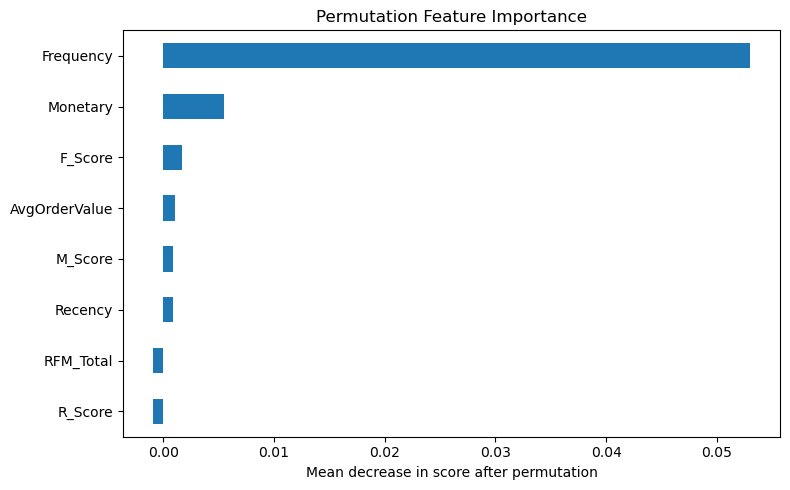

In [60]:
plt.figure(figsize=(8,5))
perm_imp.sort_values().plot(kind="barh")
plt.xlabel("Mean decrease in score after permutation")
plt.title("Permutation Feature Importance")
plt.tight_layout()
plt.show()

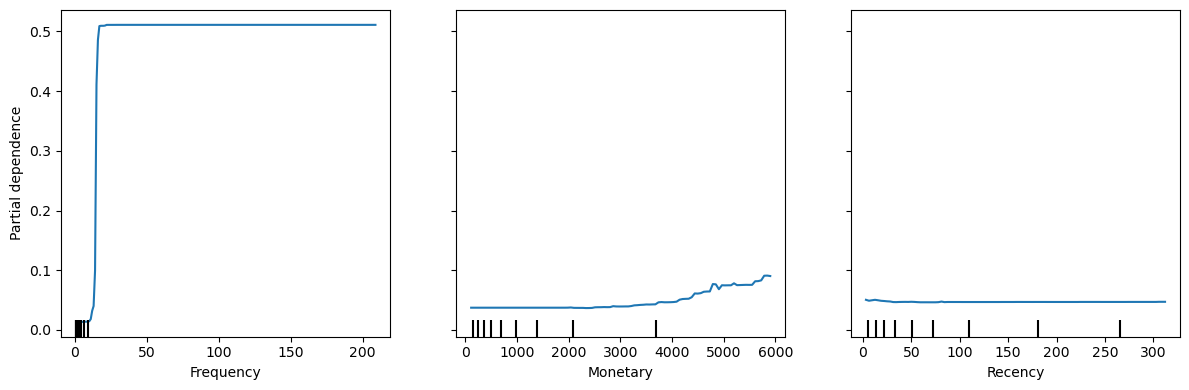

In [62]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

features = ['Frequency', 'Monetary', 'Recency']

fig, ax = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay.from_estimator(
    rf,                # your trained Random Forest
    X_train,
    features,
    kind='average',
    ax=ax
)

plt.tight_layout()
plt.show()